In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [2]:
import os
path


'/kaggle/input/new-plant-diseases-dataset'

In [3]:
os.listdir(path)


['New Plant Diseases Dataset(Augmented)',
 'new plant diseases dataset(augmented)',
 'test']

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Dataset paths
DATASET_ROOT = path
BASE_DIR = os.path.join(DATASET_ROOT, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)")
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "valid")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print("✓ Imports and paths configured")

✓ Imports and paths configured


In [5]:
# Check directory structure
print("Splits:", os.listdir(BASE_DIR))
print("Number of classes (train):", len(os.listdir(TRAIN_DIR)))

Splits: ['valid', 'train']
Number of classes (train): 38


In [6]:
# Analyze class distribution
records = []
for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    n_imgs = len(os.listdir(cls_path))
    records.append((cls, n_imgs))

df = pd.DataFrame(records, columns=["class", "count"]).sort_values("count", ascending=False)
print("\nClass Distribution:")
print(df)


Class Distribution:
                                                class  count
4                                   Soybean___healthy   2022
13                                 Apple___Apple_scab   2016
3            Orange___Haunglongbing_(Citrus_greening)   2010
27                                    Apple___healthy   2008
22                             Pepper,_bell___healthy   1988
16                                  Apple___Black_rot   1987
14             Tomato___Tomato_Yellow_Leaf_Curl_Virus   1961
29                              Potato___Early_blight   1939
24                               Potato___Late_blight   1939
1                                    Tomato___healthy   1926
32                       Grape___Esca_(Black_Measles)   1920
8                               Tomato___Early_blight   1920
36                      Pepper,_bell___Bacterial_spot   1913
7                 Corn_(maize)___Northern_Leaf_Blight   1908
31                        Corn_(maize)___Common_rust_   1907
28 


Healthy vs Diseased:
label
diseased    48001
healthy     22294
Name: count, dtype: int64


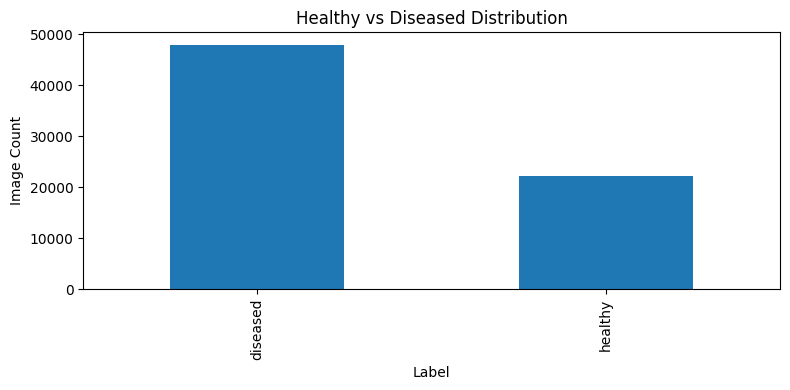

In [7]:
# Healthy vs Diseased breakdown
df["label"] = df["class"].str.lower().apply(lambda x: "healthy" if "healthy" in x else "diseased")
label_counts = df.groupby("label")["count"].sum()
print("\nHealthy vs Diseased:")
print(label_counts)

# Visualize distribution
label_counts.plot(kind="bar", figsize=(8, 4), title="Healthy vs Diseased Distribution")
plt.ylabel("Image Count")
plt.xlabel("Label")
plt.tight_layout()
plt.show()

In [8]:
# Sample image properties
sample_class = df.iloc[0]["class"]
sample_img_path = os.path.join(TRAIN_DIR, sample_class, os.listdir(os.path.join(TRAIN_DIR, sample_class))[0])
img = Image.open(sample_img_path)

print(f"\nSample Image Properties ({sample_class}):")
print(f"  Size: {img.size}")
print(f"  Color mode: {img.mode}")
print(f"  Format: {img.format}")


Sample Image Properties (Soybean___healthy):
  Size: (256, 256)
  Color mode: RGB
  Format: JPEG


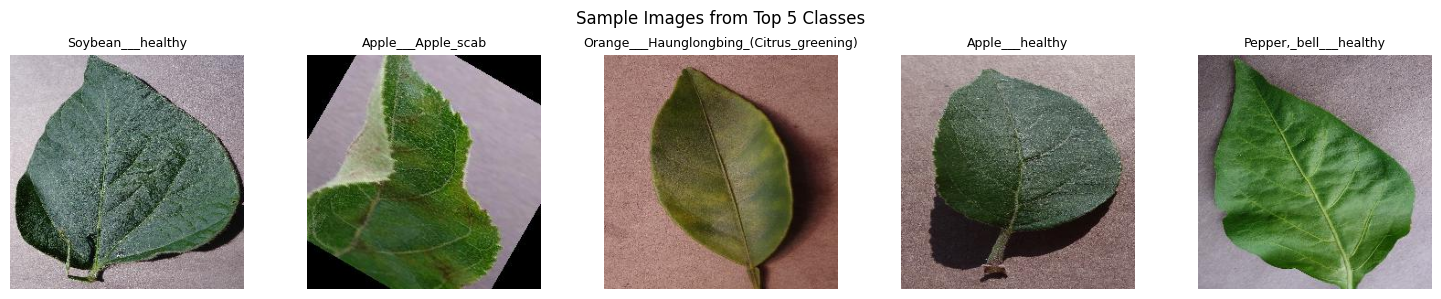

In [9]:
# Visualize example images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, cls in zip(axes, df["class"].head(5)):
    img_path = os.path.join(TRAIN_DIR, cls, os.listdir(os.path.join(TRAIN_DIR, cls))[0])
    ax.imshow(Image.open(img_path))
    ax.set_title(cls, fontsize=9)
    ax.axis("off")
plt.suptitle("Sample Images from Top 5 Classes")
plt.tight_layout()
plt.show()

In [15]:
# Find correct paths and validate dataset splits
print("Dataset Split Validation:")
print(f"  train: {TRAIN_DIR} - {'OK' if os.path.exists(TRAIN_DIR) else 'NOT FOUND'}")
print(f"  valid: {VAL_DIR} - {'OK' if os.path.exists(VAL_DIR) else 'NOT FOUND'}")
print(f"  test:  {TEST_DIR} - {'OK' if os.path.exists(TEST_DIR) else 'NOT FOUND'}")

# Search for test folder in alternative locations
test_paths = [
    os.path.join(BASE_DIR, "test"),
    os.path.join(DATASET_ROOT, "test"),
    os.path.join(DATASET_ROOT, "New Plant Diseases Dataset(Augmented)", "test"),
]

print("\nSearching for test folder...")
for p in test_paths:
    if os.path.exists(p):
        print(f"  Found: {p}")
        TEST_DIR = p
        break

print(f"\nFinal TEST_DIR: {TEST_DIR}")
print(f"Test folder exists: {os.path.exists(TEST_DIR)}")

Dataset Split Validation:
  train: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train - OK
  valid: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid - OK
  test:  /kaggle/input/new-plant-diseases-dataset/test - OK

Searching for test folder...
  Found: /kaggle/input/new-plant-diseases-dataset/test

Final TEST_DIR: /kaggle/input/new-plant-diseases-dataset/test
Test folder exists: True


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

print("✓ TensorFlow imports loaded")


✓ TensorFlow imports loaded


In [ ]:
# Data preprocessing and augmentation
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Only create test generator if TEST_DIR exists
test_generator = None
if os.path.exists(TEST_DIR):
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    print(f"✓ Data generators created (including test)")
else:
    print(f"✓ Data generators created (no test set found)")

print(f"  Number of classes: {len(train_generator.class_indices)}")
print(f"  Training batches: {len(train_generator)}")
if test_generator:
    print(f"  Test batches: {len(test_generator)}")


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test'

In [ ]:
# Build basic CNN model
n_classes = len(train_generator.class_indices)

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ CNN Model created")
model.summary()


In [ ]:
# Train the model
EPOCHS = 5

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

print("✓ Model training completed")


In [ ]:
# Evaluate on test set
if test_generator:
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"\n✓ Test Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f}")
else:
    print("\n⚠ Test set not available. Evaluating on validation set instead:")
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"  Loss: {val_loss:.4f}")
    print(f"  Accuracy: {val_accuracy:.4f}")


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
